# Multifidelity data fusion framework tutorial


Author: Mehdi Anhichem - University of Liverpool - 14/07/2022

## Introduction

<div class="jumbotron text-left"><b>
This notebook presents an application example of a simplified version of the multifidelity data fusion framework developed in Lam, Allaire and Willcox (2015) [1] and applied to aircraft wing pressure distributions in Anhichem, et al. (2022) [2].
</b></div>
The multifidelity data fusion framework is non-hierarchical which means that there is no hierarchy between the different information sources. Each information source is modelled with a Gaussian process regression, called intermediate surrogate model. Then, the expert opinion, the confidence we have on an information source, is represented by the fidelity function and incorporated on the intermediate surrogate model. The fidelity function is added to the posterior standard deviation of each Gaussian process model to form the total standard deviation. The latest aims to represent the physical accuracy of the information source and the confidence we have on the modelling process away from the training points. The multifidelity model is finally obtained with a combination of the posterior mean and the total standard deviation of the intermediate surrogate models. The combination weighting gives more importance to high-confidence values on the design space.

If the reader is unfamiliar with Gaussian process regression, an introduction tutorial is available at the following link:

[GPflow: Gaussian process regression tutorial](https://gpflow.readthedocs.io/en/v1.5.1-docs/notebooks/basics/regression.html)

The framework has been implemented with GPflow, a Gaussian process module based on Tensorflow, for the application presented in [2]. The installation of GPflow and Tensorflow is required (see installation [here](https://pypi.org/project/gpflow/)).

## 1D example with toy data
The first example will be exploiting sythetic data from three different functions on a one-dimensional input space. Let's first import the required modules! The module **MFDF_GPflow_light** contains all the tools used to build the intermediate surrogate models and the multifidelity model.

In [1]:
import numpy as np
import pandas as pd
import gpflow
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams["font.size"] = "14"
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

import MFDF_GPflow_light as MFDF

np.random.seed(123)

This example has been used in Ghoreishi and Allaire (2018) [3] to illustrate a multifidelity co-Kriging model. It defines three functions built similarly and consequently have similar evolution on the considered interval. They can be considered as an analogy of three information sources of varying cost and fidelity that inferes a physical quantity. In this example, we consider the model from function 3 to be the most costly and the most accurate while, reciprocally, function 1 is the cheapest and the less accurate. Function 2 is intermediate.

[]

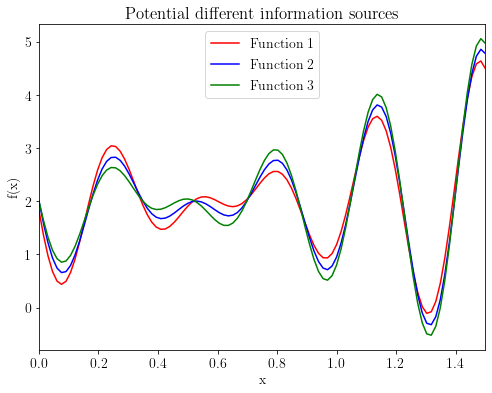

In [2]:
N = 100  
X = np.linspace(0, 1.5, N)

F1 = 2 - (1.8 - 3 * X) * np.sin(18 * X + 0.1)
F2 = 2 - (1.6 - 3 * X) * np.sin(18 * X)
F3 = 2 - (1.4 - 3 * X) * np.sin(18 * X)

plt.figure(figsize=(8, 6))
plt.plot(X, F1, "r-", mew=2, label = 'Function 1')
plt.plot(X, F2, "b-", mew=2, label = 'Function 2')
plt.plot(X, F3, "g-", mew=2, label = 'Function 3')
plt.legend(loc='upper center')
plt.xlabel("x")
plt.ylabel("f(x)")
plt.xlim([0, 1.5])
plt.title('Potential different information sources')
plt.plot()

As a consequence of their respective cost, the training data sets genenerated from each model have different size. For instance, with the same time/computational cost, we are able to obtain more data from Function 1 than Function 3. The training data are randomly generated on the input space.

[]

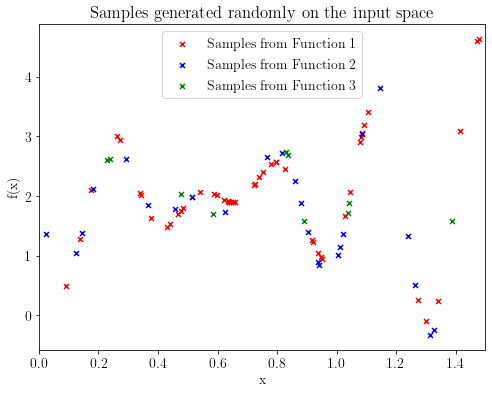

In [3]:
X1_t = 1.5*np.random.random(50)
X2_t = 1.5*np.random.random(25)
X3_t = 1.5*np.random.random(10)

F1_t = 2 - (1.8 - 3 * X1_t) * np.sin(18 * X1_t + 0.1)
F2_t = 2 - (1.6 - 3 * X2_t) * np.sin(18 * X2_t)
F3_t = 2 - (1.4 - 3 * X3_t) * np.sin(18 * X3_t)

plt.figure(figsize=(8, 6))
plt.scatter(X1_t, F1_t, s = 25, marker = 'x', c = 'r', label = 'Samples from Function 1')
plt.scatter(X2_t, F2_t, s = 25, marker = 'x', c = 'b', label = 'Samples from Function 2')
plt.scatter(X3_t, F3_t, s = 25, marker = 'x', c = 'g', label = 'Samples from Function 3')
plt.legend(loc='upper center')
plt.xlabel("x")
plt.ylabel("f(x)")
plt.xlim([0, 1.5])
plt.title('Samples generated randomly on the input space')
plt.plot()

The multifidelity data fusion framework is based on the construction of intermediate surrogate models with Gaussian process regression. The following code defines and trains Gaussian process for each model. It outputs a summary of the posterior a Gaussian process parameters.

In [4]:
print('Gaussian process prior and posterior - Model 1:')
kernel1 = gpflow.kernels.SquaredExponential(variance= 0.1, lengthscales = 0.1)
model1 = MFDF.IntermediateSurrogate([X1_t], F1_t, kernel1)

print('Gaussian process prior and posterior - Model 2:')
kernel2 = gpflow.kernels.SquaredExponential(variance= 0.1, lengthscales = 0.1)
model2 = MFDF.IntermediateSurrogate([X2_t], F2_t, kernel2)

print('Gaussian process prior and posterior - Model 3:')
kernel3 = gpflow.kernels.SquaredExponential(variance= 0.1, lengthscales = 0.1)
model3 = MFDF.IntermediateSurrogate([X3_t], F3_t, kernel3)

Gaussian process prior and posterior - Model 1:
╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │   value │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═════════╡
│ GPR.kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │   0.1   │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ GPR.kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │   0.1   │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ GPR.likelihood.variance │ Parameter │ Softplus + Shift │         │ True        │ ()      │ float64 │   0.001 │
╘═════════════════════════╧═══════════╧═════════

Predictions of the intermediate surrogate models are then produced and plotted. The resulting plot presents the posterior mean of each intermediate model (dashed line) and their posterior standard deviation (transparent area). It can be observed that the variations of Model 3 posterior mean seem to be different from the function 3 and its corresponding standard deviation is relatively high. It due to the lack of training data in those regions. The abundance of data for the two other information sources explain a more accurate shape and lower values of standard deviation.

[]

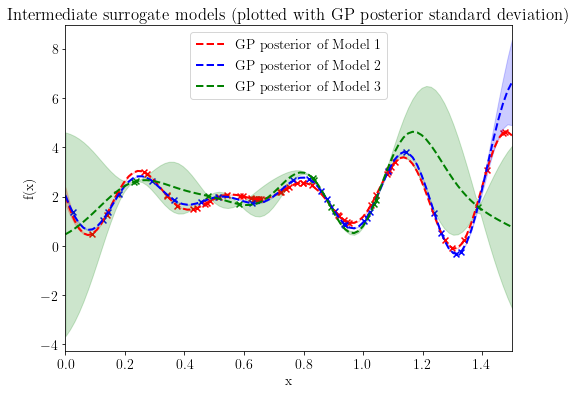

In [5]:
N_predictions = 500  
X_predictions = np.linspace(0, 1.5, N) 

# Prediction input vector shape needs to be (N_predictions,1)
Y1_mean, Y1_std = MFDF.Predict(model1, X_predictions.reshape(-1,1))
Y2_mean, Y2_std = MFDF.Predict(model2, X_predictions.reshape(-1,1))
Y3_mean, Y3_std = MFDF.Predict(model3, X_predictions.reshape(-1,1))

# Plot intermediate surrogate models
plt.figure(figsize=(8, 6))
plt.scatter(X1_t, F1_t, s = 35, marker = 'x', c = 'r')
plt.plot(X_predictions, Y1_mean, 'r--', lw=2, label = 'GP posterior of Model 1')
plt.fill_between(X_predictions, Y1_mean[:, 0] - 1.96 * Y1_std[:, 0], Y1_mean[:, 0] + 1.96 * Y1_std[:, 0], color='r', alpha=0.2)
plt.scatter(X2_t, F2_t, s = 35, marker = 'x', c = 'b')
plt.plot(X_predictions, Y2_mean, 'b--', lw=2, label = 'GP posterior of Model 2')
plt.fill_between(X_predictions, Y2_mean[:, 0] - 1.96 * Y2_std[:, 0], Y2_mean[:, 0] + 1.96 * Y2_std[:, 0], color='b', alpha=0.2)
plt.scatter(X3_t, F3_t, s = 35, marker = 'x', c = 'g')
plt.plot(X_predictions, Y3_mean, 'g--', lw=2, label = 'GP posterior of Model 3')
plt.fill_between(X_predictions, Y3_mean[:, 0] - 1.96 * Y3_std[:, 0], Y3_mean[:, 0] + 1.96 * Y3_std[:, 0], color='g', alpha=0.2)
plt.legend(loc='upper center')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.xlim([0.0, 1.5])
plt.title('Intermediate surrogate models (plotted with GP posterior standard deviation)')
plt.plot()

The next step in the multifidelity model construction is to define a fidelity function on the input space. It aims to represent the confidence we have on an information source. As stated at the beginning of the example, we supposed variable accuracy of the different models. For this example, we defined the fidelity function as a constant on the input space. The following plot is similar to the previous but presents, this time, the total standard deviation corresponding to the transparent area. It can thus be observed that the total standard deviation of Model 1 increased and is now higher than other models at some locations.

[]

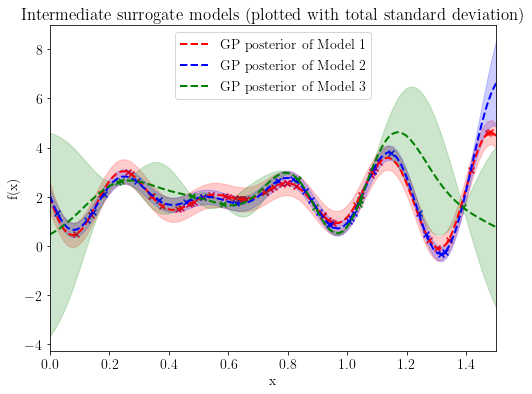

In [6]:
# Fidelity function
Y1_fid_std = MFDF.FidelityStd(X_predictions, 0.25)
Y2_fid_std = MFDF.FidelityStd(X_predictions, 0.15)
Y3_fid_std = MFDF.FidelityStd(X_predictions, 0.0)

# Plot intermediate surrogate with total standard deviation
Y1_std_tot = np.sqrt(Y1_std**2 + Y1_fid_std**2)
Y2_std_tot = np.sqrt(Y2_std**2 + Y2_fid_std**2)
Y3_std_tot = np.sqrt(Y3_std**2 + Y3_fid_std**2)

plt.figure(figsize=(8, 6))
plt.scatter(X1_t, F1_t, s = 35, marker = 'x', c = 'r')
plt.plot(X_predictions, Y1_mean, 'r--', lw=2, label = 'GP posterior of Model 1')
plt.fill_between(X_predictions, Y1_mean[:, 0] - 1.96 * Y1_std_tot[:, 0], Y1_mean[:, 0] + 1.96 * Y1_std_tot[:, 0], color='r', alpha=0.2)
plt.scatter(X2_t, F2_t, s = 35, marker = 'x', c = 'b')
plt.plot(X_predictions, Y2_mean, 'b--', lw=2, label = 'GP posterior of Model 2')
plt.fill_between(X_predictions, Y2_mean[:, 0] - 1.96 * Y2_std_tot[:, 0], Y2_mean[:, 0] + 1.96 * Y2_std_tot[:, 0], color='b', alpha=0.2)
plt.scatter(X3_t, F3_t, s = 35, marker = 'x', c = 'g')
plt.plot(X_predictions, Y3_mean, 'g--', lw=2, label = 'GP posterior of Model 3')
plt.fill_between(X_predictions, Y3_mean[:, 0] - 1.96 * Y3_std_tot[:, 0], Y3_mean[:, 0] + 1.96 * Y3_std_tot[:, 0], color='g', alpha=0.2)
plt.legend(loc='upper center')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.xlim([0.0, 1.5])
plt.title('Intermediate surrogate models (plotted with total standard deviation)')
plt.plot()

The multifidelity model is obtained by a variance-weighted combination of the posterior mean and the total standard deviation of all intermediate surrogate models. The next plot compares the resulting multifidelity model with the single-fidelity model based on Model 3. It can be observed that the multifidelity model is more accurate as it benefits from all information available. Therefore, the standard deviation is low on the whole design space. It shows that the resulting model respects the ‘ground truth’ of Model 3 and learns the function evolution from the more resolved data sets to obtain a reliable surrogate.

[]

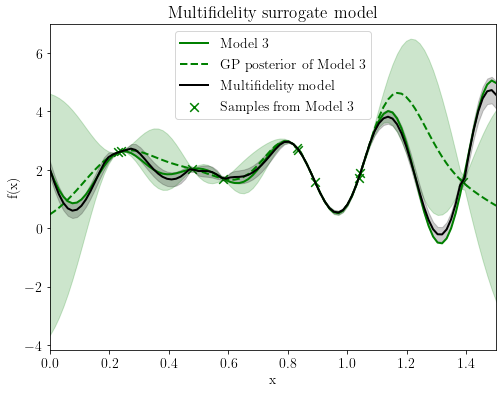

In [7]:
# Fusing on prediction subspace
IntermediateSurrogates = [[Y1_mean, Y1_std, Y1_fid_std],
                          [Y2_mean, Y2_std, Y2_fid_std],
                          [Y3_mean, Y3_std, Y3_fid_std]]

Y_mean_multi, Y_std_multi = MFDF.MultifidelityFusion(IntermediateSurrogates)

# Plot and comparison
plt.figure(figsize=(8, 6))
plt.plot(X, F3, "g-", lw=2, label = 'Model 3')
plt.scatter(X3_t, F3_t, s = 75, marker = 'x', c = 'g', label = 'Samples from Model 3')
plt.plot(X_predictions, Y3_mean, 'g--', lw=2, label = 'GP posterior of Model 3')
plt.fill_between(X_predictions, Y3_mean[:, 0] - 1.96 * Y3_std_tot[:, 0], Y3_mean[:, 0] + 1.96 * Y3_std_tot[:, 0], color='g', alpha=0.2)
plt.plot(X_predictions, Y_mean_multi, 'k', lw=2, label = 'Multifidelity model')
plt.fill_between(X_predictions, Y_mean_multi[:, 0] - 1.96 * Y_std_multi[:, 0], Y_mean_multi[:, 0] + 1.96 * Y_std_multi[:, 0], color='k', alpha=0.2)
plt.legend(loc='upper center')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.xlim([0.0, 1.5])
plt.title('Multifidelity surrogate model')
plt.plot()

## References

[1] Lam, R., Allaire, D. L., and Willcox, K. E. Multifidelity Optimization Using Statistical Surrogate Modeling for Non-Hierarchical Information Sources. Presented at the 56th AIAA/ASCE/AHS/ASC Structures, Structural Dynamics, and Materials Conference, Kissimmee, Florida, 2015.

[2] Anhichem, M., Timme, S., Castagna, J., Peace, A., and Maina, M. Multifidelity Data Fusion Applied to Aircraft Wing Pressure Distribution. Presented at the AIAA AVIATION 2022 Forum, Chicago, IL & Virtual, 2022.

[3] Ghoreishi, S. F., and Allaire, D. L. Gaussian Process Regression for Bayesian Fusion of Multi-Fidelity Information Sources. Presented at the 2018 Multidisciplinary Analysis and Optimization Conference, Atlanta, Georgia, 2018.